In [1]:
###### test connection ######

import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"

In [2]:
###### check environments ######

import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])

ocid1.tenancy.oc1..aaaaaaaazsst3y4ltnibxw2e56dsmdlwkc7zoshzpkst7hkgfgite4csmhoa
ocid1.datascienceproject.oc1.eu-zurich-1.amaaaaaa2jwq32iapkcl4klg3qulxmpxlgnyxwhf276mb6ukgtdhms5oc3ua
ocid1.saml2idp.oc1..aaaaaaaao4zb7iwgmzbhs3hcvl7qrob453qzrqzs3o2hhl23oczezxmtyz7q/ethlambda@gmail.com
ocid1.tenancy.oc1..aaaaaaaazsst3y4ltnibxw2e56dsmdlwkc7zoshzpkst7hkgfgite4csmhoa
eu-zurich-1


In [21]:
%%bash
###### install libs ######
#pip install matplotlib
#pip install pandas
#pip install seaborn
#pip list
#pip install scikit-learn

In [3]:
###### import libs ######

%matplotlib inline
%reload_ext autoreload
%autoreload 2

import gzip
import pickle
import logging
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator

plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams['font.size'] = 15
sns.set(color_codes=True)
sns.set(font_scale=1.5)
sns.set_palette("bright")
sns.set_style("whitegrid")

In [4]:
###### check ads env ######

ads.environment.ads_inspect.check_ads_env()

Library         Version    Required
--------------  ---------  ----------
arrow           0.14.7     0.10.0
configparser    4.0.2      3.5.0
ipykernel       5.4.0      5.1.3
pyod            0.8.1      0.7.1
pyOpenSSL       18.0.0     19.0
pytest          4.0.1      5.3.5
pytest-asyncio  0.9.0      0.10.0
six             1.14.0     1.13


In [5]:
####### load data #######

name = 'eeg_outlier'
id_col = ""
target_col = "Eye"

train_name = './{}/train_{}.csv'.format(name, name)
test_name = './{}/test_{}.csv'.format(name, name)

df = pd.read_csv(train_name)
test_df = pd.read_csv(test_name)

print(df.head())
df.shape

test_df.head()

       AF3       F7       F3      FC5       T7       P7       O1       O2  \
0  4288.72  4028.72  4240.51  4123.59  4344.62  4608.72  4055.38  4611.79   
1  4268.21  4002.56  4232.82  4085.13  4336.41  4622.56  4107.18  4629.23   
2  4300.51  4023.08  4278.46  4149.23  4348.72  4614.87  4057.44  4608.21   
3  4271.79  3980.51  4251.79  4107.18  4329.23  4609.23  4053.85  4613.33   
4  4433.85  4120.51  4313.85  4176.41  4356.92  4615.90  4069.74  4611.28   

        P8       T8      FC6       F4       F8      AF4  Eye  
0  4187.18  4230.77  4194.87  4265.64  4580.00  4345.64    0  
1  4221.03  4230.77  4189.74  4277.44  4617.95  4331.28    1  
2  4193.85  4228.21  4215.38  4283.59  4613.33  4367.18    0  
3  4192.82  4222.05  4197.95  4258.97  4578.46  4340.51    1  
4  4189.23  4226.15  4211.79  4306.15  4664.10  4479.49    0  


,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,Eye
0,4343.59,3971.79,4265.13,4092.31,4326.67,4618.97,4100.00,4626.15,4205.64,4227.69,4238.46,4309.74,4654.36,4403.08,1
1,4431.79,4072.31,4304.62,4154.36,4350.77,4621.03,4077.44,4601.54,4211.28,4275.90,4249.74,4321.54,4685.64,4476.41,0
2,4316.41,4037.44,4247.18,4134.87,4327.69,4592.82,4048.21,4598.46,4190.26,4216.92,4177.44,4257.95,4588.21,4365.64,1
3,4285.13,3996.41,4260.51,4108.72,4333.33,4617.95,4064.10,4625.13,4203.08,4229.23,4201.54,4281.03,4606.15,4354.36,0
4,4288.72,4018.46,4267.69,4131.79,4338.97,4629.23,4086.15,4616.41,4191.79,4221.03,4196.41,4270.77,4590.26,4336.92,1


[0 1]


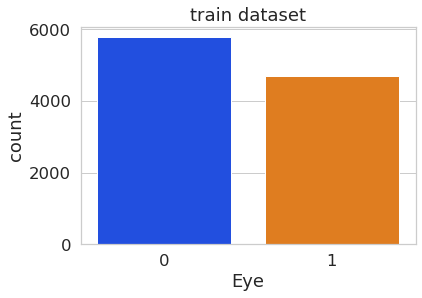

In [6]:
### dataset statistics ######
sns.countplot(x=target_col, data=df)
plt.title("train dataset")
print(df[target_col].unique())

In [7]:
###### train model ######

train = DatasetFactory.open(df).set_target(target_col)
print([train])

# create an automl job
ml_engine = OracleAutoMLProvider(n_jobs=-1, loglevel=logging.ERROR)
oracle_automl = AutoML(training_data = train, provider=ml_engine)

# time budget is in seconds
best_model, baseline = oracle_automl.train(score_metric='roc_auc', time_budget=600)

[BinaryClassificationDataset(target: Eye) 10,486 rows, 15 columns]


Training Dataset size,"(10486, 14)"
Validation Dataset size,None
CV,5
Target variable,Eye
Optimization Metric,roc_auc
Initial number of Features,14
Selected number of Features,14
Selected Features,"[AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6, F4, F8, AF4]"
Selected Algorithm,LGBMClassifier
End-to-end Elapsed Time (seconds),76.21
Selected Hyperparameters,"{'boosting_type': 'gbdt', 'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_weight': 0.001, 'n_estimators': 253, 'num_leaves': 190, 'reg_alpha': 0, 'reg_lambda': 1}"


Rank based on Performance,Algorithm,#Samples,#Features,Mean Validation Score,Hyperparameters,CPU Time
2,LGBMClassifier_HT,10486,14,0.9669,"{'boosting_type': 'gbdt', 'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_weight': 0.001, 'n_estimators': 253, 'num_leaves': 189, 'reg_alpha': 0, 'reg_lambda': 1}",9.6517
3,LGBMClassifier_HT,10486,14,0.9669,"{'boosting_type': 'gbdt', 'class_weight': None, 'learning_rate': 0.1, 'max_depth': -1, 'min_child_weight': 0.001, 'n_estimators': 253, 'num_leaves': 190, 'reg_alpha': 0, 'reg_lambda': 1}",8.3780
4,LGBMClassifier_HT,10486,14,0.9650,"{'boosting_type': 'gbdt', 'class_weight': 'balanced', 'learning_rate': 0.10242113515453982, 'max_depth': -1, 'min_child_weight': 1.1246826503806984, 'n_estimators': 253, 'num_leaves': 189, 'reg_alpha': 1e-10, 'reg_lambda': 2.0000099998e-05}",6.9573
5,LGBMClassifier_HT,10486,14,0.9650,"{'boosting_type': 'gbdt', 'class_weight': None, 'learning_rate': 0.10242113515453982, 'max_depth': -1, 'min_child_weight': 1.1246826503806984, 'n_estimators': 253, 'num_leaves': 189, 'reg_alpha': 1e-10, 'reg_lambda': 2.0000099998e-05}",5.7781
6,LGBMClassifier_AS,5000,14,0.9641,"{'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_weight': 0.001, 'n_estimators': 100, 'num_leaves': 31, 'reg_alpha': 0, 'reg_lambda': 1, 'class_weight': 'balanced'}",2.5274
...,...,...,...,...,...,...
194,LGBMClassifier_HT,10486,14,0.5560,"{'boosting_type': 'dart', 'class_weight': 'balanced', 'learning_rate': 0.0001, 'max_depth': 1, 'min_child_weight': 0.0, 'n_estimators': 6, 'num_leaves': 3, 'reg_alpha': 1e-10, 'reg_lambda': 1e-10}",0.1314
195,LGBMClassifier_HT,10486,14,0.5560,"{'boosting_type': 'dart', 'class_weight': 'balanced', 'learning_rate': 0.0001, 'max_depth': 1, 'min_child_weight': 0.0, 'n_estimators': 100, 'num_leaves': 3, 'reg_alpha': 1e-10, 'reg_lambda': 1e-10}",0.5293
196,LGBMClassifier_HT,10486,14,0.5560,"{'boosting_type': 'dart', 'class_weight': 'balanced', 'learning_rate': 0.0001, 'max_depth': 1, 'min_child_weight': 0.0, 'n_estimators': 101, 'num_leaves': 3, 'reg_alpha': 1e-10, 'reg_lambda': 1e-10}",0.6131
197,LGBMClassifier_HT,10486,14,0.5560,"{'boosting_type': 'dart', 'class_weight': 'balanced', 'learning_rate': 0.0001, 'max_depth': 1, 'min_child_weight': 0.0, 'n_estimators': 5, 'num_leaves': 3, 'reg_alpha': 1e-10, 'reg_lambda': 1}",0.1254


In [8]:
###### predict test dataset ######

print(test_df.shape)

y_pred = best_model.predict(test_df)
y_pred_prob = best_model.predict_proba(test_df)
y_true = test_df[target_col]
print(y_true.shape)

test_acc = np.mean(y_pred==y_true)
print("test accuracy = {}".format(test_acc))

import sklearn
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred_prob[:, 1], pos_label=1)
test_auc = metrics.auc(fpr, tpr)
print("test auc = {}".format(test_auc))

(4494, 15)
(4494,)
test accuracy = 0.9528259902091678
test auc = 0.991862964034365


In [26]:
oracle_automl.print_trials(max_rows=129, sort_column='Mean Validation Score')

Algorithm,#Samples,#Features,Mean Validation Score,Hyperparameters,CPU Time
RandomForestClassifier_HT,29492,9,0.9261,"{'class_weight': 'balanced_subsample', 'max_features': 0.1111111111111111, 'min_samples_leaf': 3.3907500339075e-05, 'min_samples_split': 6.781500067815e-05, 'n_estimators': 253}",21.8383
RandomForestClassifier_HT,29492,9,0.9259,"{'class_weight': None, 'max_features': 0.1111111111111111, 'min_samples_leaf': 3.3907500339075e-05, 'min_samples_split': 6.781500067815e-05, 'n_estimators': 253}",16.8325
RandomForestClassifier_HT,29492,9,0.9258,"{'class_weight': None, 'max_features': 0.1111111111111111, 'min_samples_leaf': 3.3907500339075e-05, 'min_samples_split': 6.781500067815e-05, 'n_estimators': 252}",15.9579
RandomForestClassifier_HT,29492,9,0.9251,"{'class_weight': None, 'max_features': 0.1111111111111111, 'min_samples_leaf': 3.3907500339075e-05, 'min_samples_split': 6.781500067815e-05, 'n_estimators': 101}",6.5867
RandomForestClassifier_HT,29492,9,0.9251,"{'class_weight': None, 'max_features': 0.1111111111111111, 'min_samples_leaf': 3.3907500339075e-05, 'min_samples_split': 6.781500067815e-05, 'n_estimators': 100}",6.4813
RandomForestClassifier_HT,29492,9,0.9249,"{'class_weight': 'balanced', 'max_features': 0.1111111111111111, 'min_samples_leaf': 3.3907500339075e-05, 'min_samples_split': 6.781500067815e-05, 'n_estimators': 253}",17.0242
RandomForestClassifier_HT,29492,9,0.9155,"{'class_weight': 'balanced_subsample', 'max_features': 0.777777778, 'min_samples_leaf': 0.00041425204389354867, 'min_samples_split': 0.00125, 'n_estimators': 253}",54.0380
RandomForestClassifier_HT,29492,9,0.9138,"{'class_weight': 'balanced', 'max_features': 0.777777778, 'min_samples_leaf': 0.00041425204389354867, 'min_samples_split': 0.0012599993218499932, 'n_estimators': 100}",19.4435
RandomForestClassifier_HT,29492,9,0.9138,"{'class_weight': 'balanced', 'max_features': 0.777777778, 'min_samples_leaf': 0.00041925170481854526, 'min_samples_split': 0.00125, 'n_estimators': 100}",19.5491
RandomForestClassifier_HT,29492,9,0.9138,"{'class_weight': 'balanced', 'max_features': 0.777777778, 'min_samples_leaf': 0.00041425204389354867, 'min_samples_split': 0.00125, 'n_estimators': 100}",19.4114


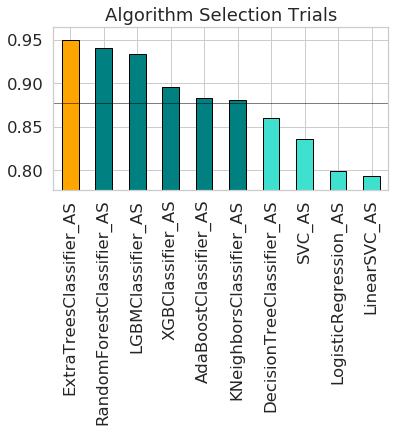

In [11]:
oracle_automl.visualize_algorithm_selection_trials()

In [14]:
###### load kaggle test dataset ######
kaggle_test_name = './d_pis/kaggle-test_{}.csv'.format(name)

kaggle_test_df = pd.read_csv(kaggle_test_name)
kaggle_test_id = np.arange(1, kaggle_test_df.shape[0]  + 1)

print(kaggle_test_df.head())
kaggle_test_df.shape

   A_follower_count  A_following_count  A_listed_count  A_mentions_received  \
0            614689                400            5729           199.618296   
1            739581              10723            1279           102.026750   
2              3638               3341              85             2.793577   
3               613               1259              31             1.326041   
4           1352348                331           15647         19129.848662   

   A_retweets_received  A_mentions_sent  A_retweets_sent    A_posts  \
0            67.812469         9.366192         0.359534   4.094488   
1            96.771319         1.537322         1.054358   3.467754   
2             1.402703         2.594089         0.598150   3.802143   
3             0.356943         6.249678         2.323064   7.488116   
4         14552.733991         2.065418         0.580955  16.281502   

   A_network_feature_1  A_network_feature_2  ...  B_following_count  \
0                  669     

(5952, 22)

In [15]:
###### predict kaggle test dataset ######

kaggle_y_pred = best_model.predict(kaggle_test_df)

assert kaggle_y_pred.shape == kaggle_test_id.shape

print(kaggle_y_pred.shape)
print(kaggle_y_pred[:100])

(5952,)
[0 0 0 0 0 0 1 1 0 1 0 1 1 0 1 1 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 1 1 1 1 0 0
 0 1 1 1 0 0 1 0 1 0 0 0 1 0 0 0 1 1 0 0 1 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1
 0 1 0 1 0 0 0 0 0 1 0 0 1 0 1 1 0 0 1 1 0 0 1 0 0 0]


In [16]:
###### save kaggle prediction ######

kaggle_pred_name = './d_pis/kaggle-test_{}_predictions.csv'.format(name)

kaggle_pred_df = pd.DataFrame({id_col: kaggle_test_id, target_col: kaggle_y_pred})
print(kaggle_pred_df.head())

kaggle_pred_df.to_csv(kaggle_pred_name, index=False)

   Id  Choice
0   1       0
1   2       0
2   3       0
3   4       0
4   5       0
